<a href="https://colab.research.google.com/github/orevs-com/Stock-Market-Project/blob/main/MSc_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhanced Stock Price Prediction Using LSTM with Technical Indicators: A Comparative Study with XGBoost and ARIMA by **Orevaoghene Otiede**

## Installing/Importing the Required Libraries for the Project

In [1]:
# Installing compatible Numpy version
!pip uninstall numpy pmdarima -y
!pip install numpy==1.26.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
# Install necessary libraries
!pip install pandas_ta statsmodels xgboost
!pip install pmdarima yfinance tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 3.3 MB/s eta 0:00:00
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218984 sha256=a84cee27183550e65f6bccf3826f433b4ee0f9b4798451f655c6d9584f93cd37
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
 

In [2]:
# Corrcting the numpy import for pandas_ta
path = "/usr/local/lib/python3.11/dist-packages/pandas_ta/momentum/squeeze_pro.py"

# Read the file and replace the line
with open(path, 'r') as file:
    content = file.read()

# Replace the incorrect import
content = content.replace("from numpy import NaN as npNaN", "from numpy import nan as npNaN")

# Write the updated content back
with open(path, 'w') as file:
    file.write(content)

print("File updated successfully.")

File updated successfully.


In [3]:
# Importing necessary Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import xgboost as xgb
import pandas_ta as ta
import os

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Mount Google Drive

In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
    # Define a path in Google Drive to save/load data/models
    Drive_Path = '/content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/'
    # Create the directory if it doesn't exist
    os.makedirs(Drive_Path, exist_ok=True)
    print(f"Working directory set to: {Drive_Path}")
except ImportError:
    print("Not in Google Colab environment. Skipping Google Drive mount.")
    Drive_Path = './'

Mounted at /content/drive
Google Drive mounted successfully!
Working directory set to: /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/


## Downloading Stock Data from yfinance

[*********************100%***********************]  1 of 1 completed


Data for AAPL downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for MSFT downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for GOOGL downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for AMZN downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for NVDA downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for META downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for TSLA downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for AVGO downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for COST downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for NFLX downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for ADBE downloaded. Shape: (2515, 5)


[*********************100%***********************]  1 of 1 completed


Data for INTC downloaded. Shape: (2515, 5)

--- Saving Raw Data to CSV Files ---
Data for AAPL saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/AAPL.csv
Data for MSFT saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/MSFT.csv
Data for GOOGL saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/GOOGL.csv
Data for AMZN saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/AMZN.csv
Data for NVDA saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/NVDA.csv
Data for META saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/META.csv
Data for TSLA saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/TSLA.csv
Data for AVGO saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/AVGO.csv
Data for COST saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/COST.csv
Data for NFLX saved to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/NFLX.csv
Data for ADBE saved to /con

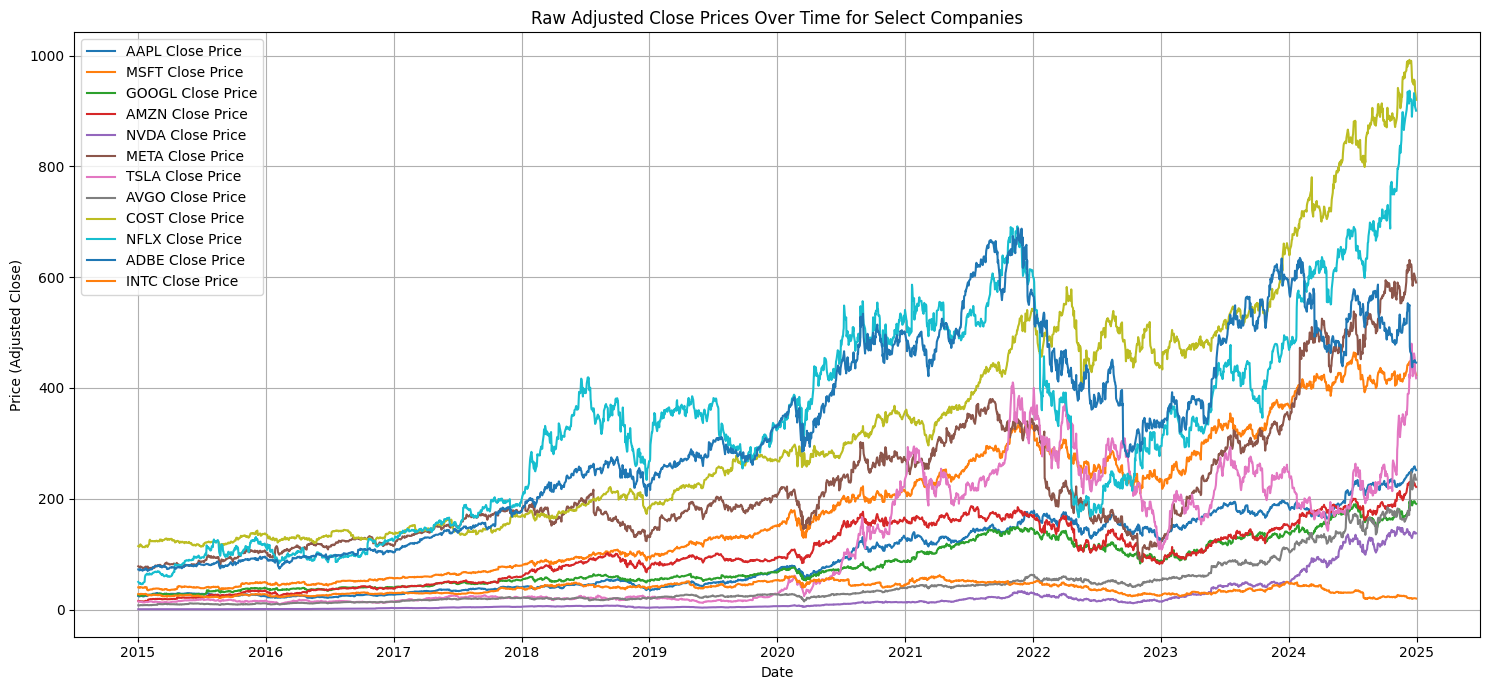

In [5]:
Tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META',
           'TSLA', 'AVGO', 'COST', 'NFLX', 'ADBE', 'INTC']
Start_Date = '2015-01-01'
End_Date = '2024-12-31'

Drive_Path = '/content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/'

def download_stock_data(ticker, start, end):
    print(f"Downloading data for {ticker} from {start} to {end} ...")
    df = yf.download(ticker, start=start, end=end, auto_adjust=True)
    if df.empty:
        print(f"No data downloaded for {ticker}.")
    else:
        print(f"Data for {ticker} downloaded. Shape: {df.shape}")
    return df

all_raw_data = {}
for ticker in Tickers:
    data = download_stock_data(ticker, Start_Date, End_Date)
    if not data.empty:
        all_raw_data[ticker] = data

if not all_raw_data:
    print("No data available for any ticker after download.")
    exit()

# Save data to CSV files
print("\n--- Saving Raw Data to CSV Files ---")
for ticker, df in all_raw_data.items():
    if not df.empty:
        filename = os.path.join(Drive_Path, f"{ticker}.csv")
        df.to_csv(filename)
        print(f"Data for {ticker} saved to {filename}")

# Graphical Representation of Raw Data
print("\n--- Visualizing Raw Close Prices ---")
plt.figure(figsize=(15, 7))
for ticker, df in all_raw_data.items():
    if not df.empty:
        plt.plot(df.index, df['Close'], label=f'{ticker} Close Price')
plt.title('Raw Adjusted Close Prices Over Time for Select Companies')
plt.xlabel('Date')
plt.ylabel('Price (Adjusted Close)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Calculating Technical Indicators for Stock Data

Processing 12 CSV files in /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/...
Calculating technical indicators for NFLX...
  Dropped 200 rows with NaN values for NFLX.
Technical indicators and lagged features calculated for NFLX.
Successfully processed and saved NFLX data to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/NFLX_indicators_lagged.csv
Calculating technical indicators for AAPL...
  Dropped 200 rows with NaN values for AAPL.
Technical indicators and lagged features calculated for AAPL.
Successfully processed and saved AAPL data to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/AAPL_indicators_lagged.csv
Calculating technical indicators for AVGO...
  Dropped 200 rows with NaN values for AVGO.
Technical indicators and lagged features calculated for AVGO.
Successfully processed and saved AVGO data to /content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/AVGO_indicators_lagged.csv
Calculating techni

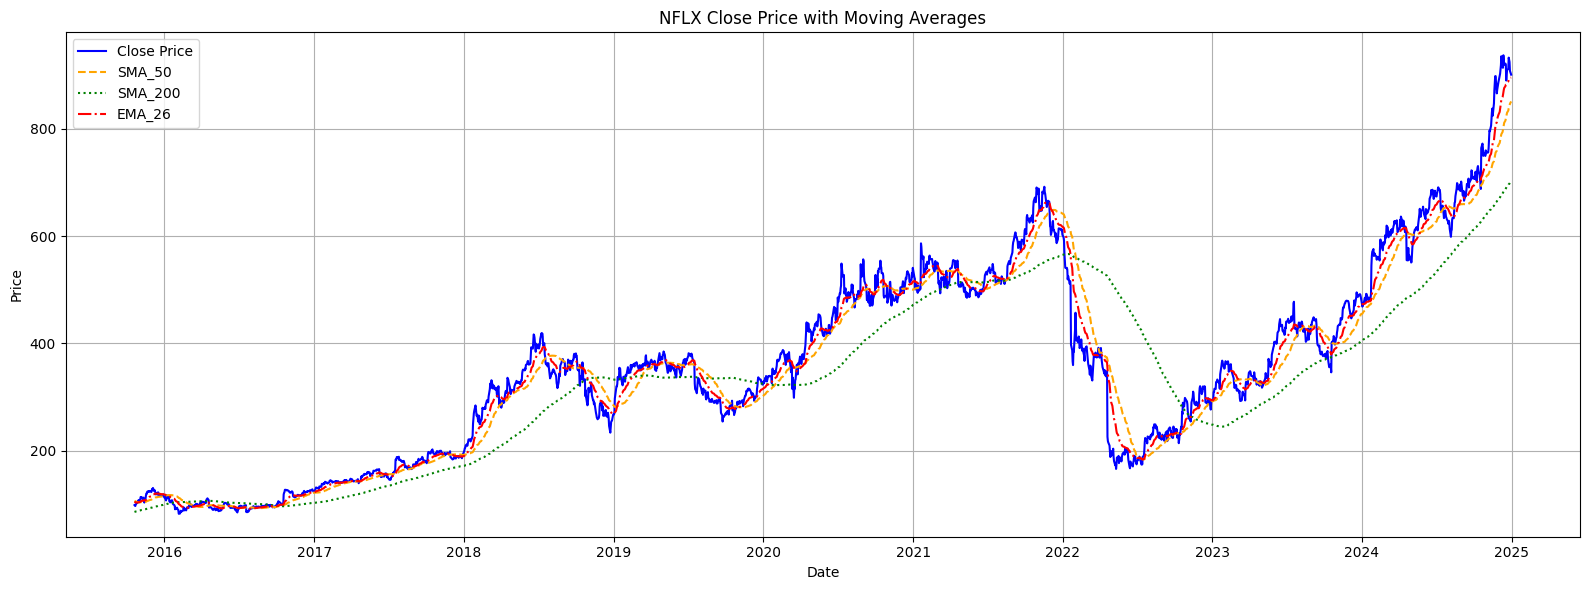

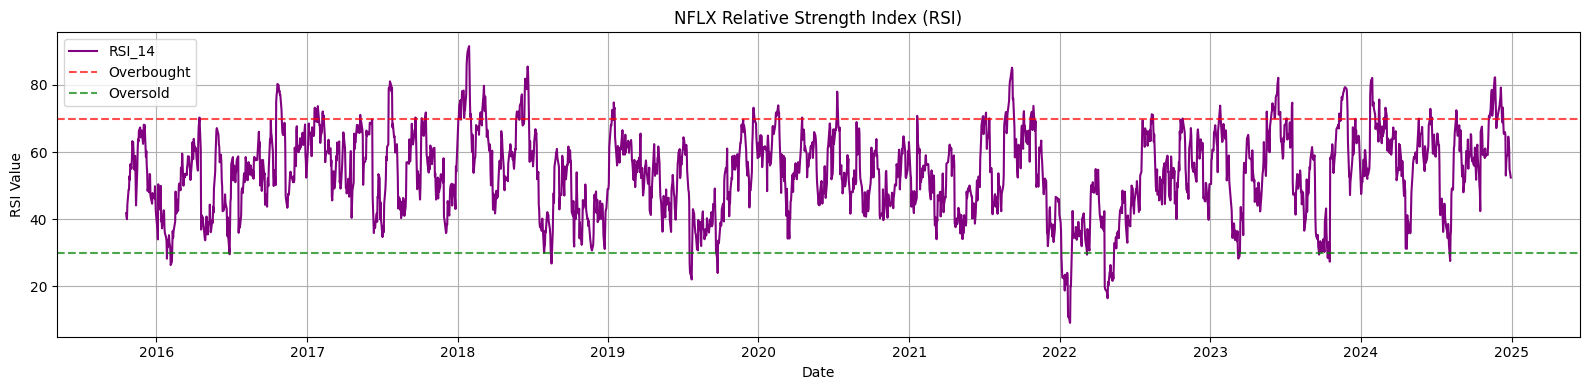

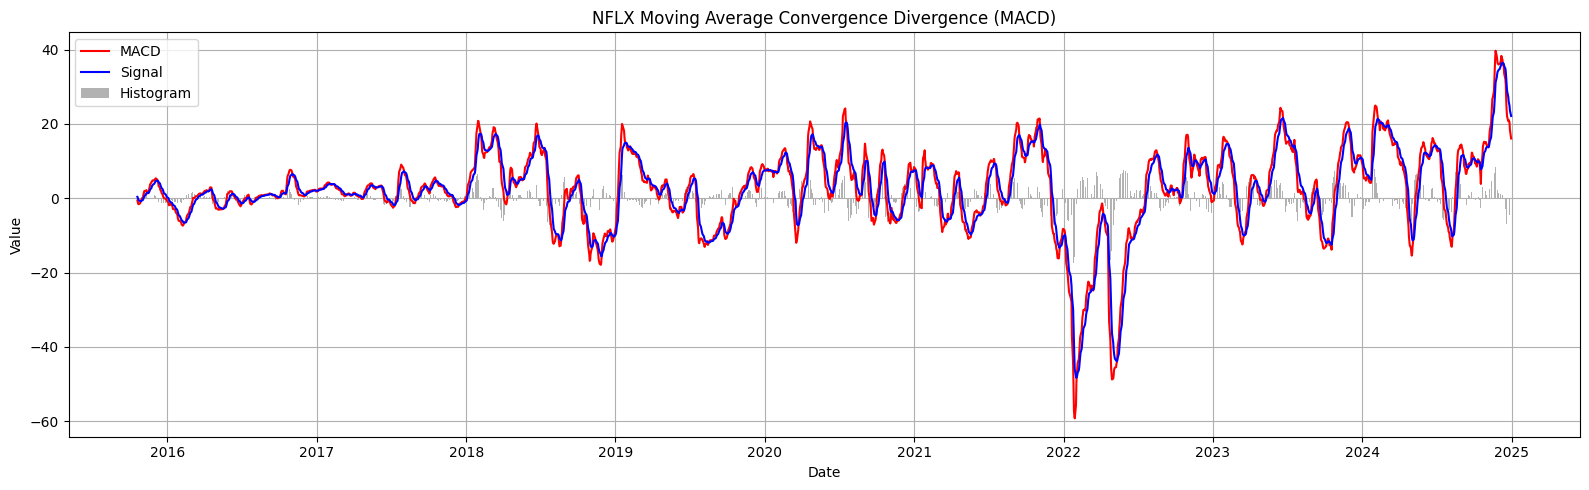

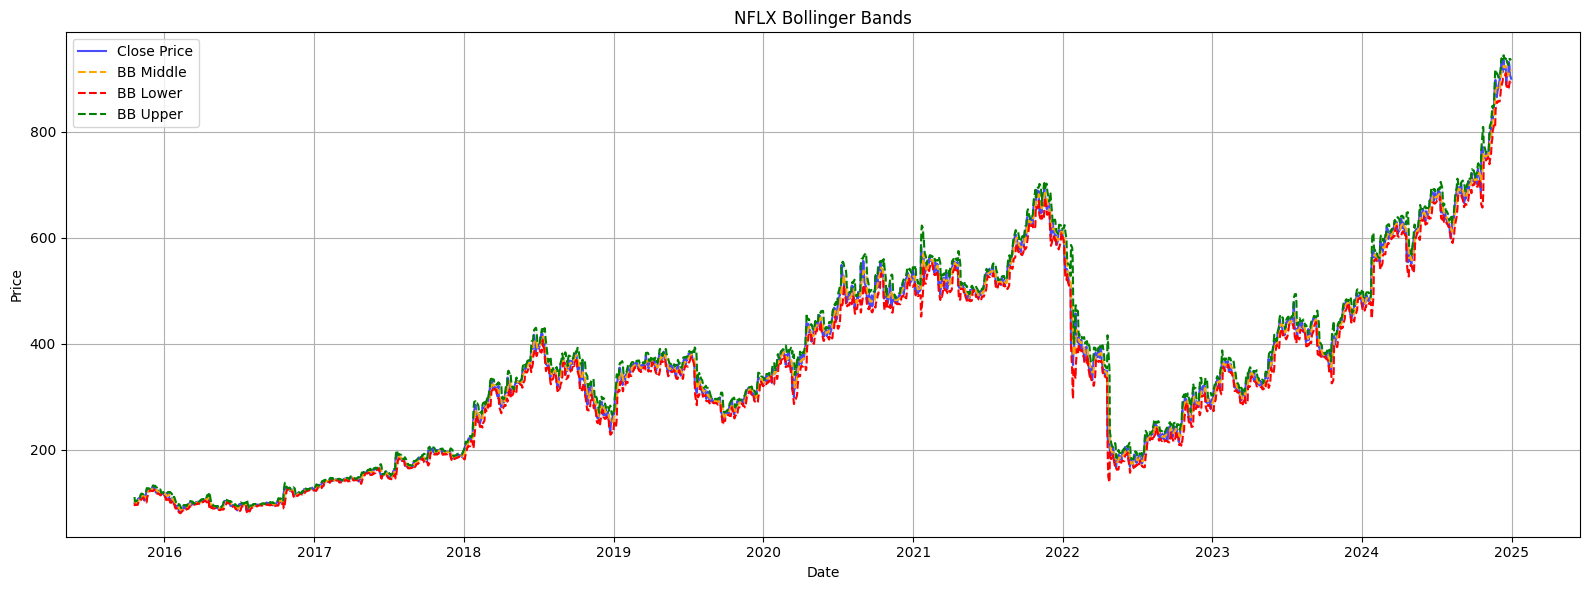

In [6]:
# Defining Drive Paths for Input and Output Data
Drive_Path = '/content/drive/MyDrive/Colab Notebooks/Stock_Market_Data/'
Output_Drive_Path = '/content/drive/MyDrive/Colab Notebooks/Stock_Market_Data_With_Indicators/'

# Ensure the output directory exists
os.makedirs(Output_Drive_Path, exist_ok=True)

# Function to Calculate Technical Indicators with Lagged Features
def calculate_indicators_and_lag_features(df, ticker_name):
    """
    This function calculates various technical indicators and adds lagged
    features to the DataFrame.
    It also includes robust checks and handles potential errors
    during calculation.
    """
    if df.empty:
        print(f"Skipping {ticker_name}: DataFrame is empty.")
        return df

    # Ensure required columns are present in saved data
    required_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
    if not all(col in df.columns for col in required_cols):
        print(f"Skipping {ticker_name}: Missing one or more of OHLCV columns.")
        return df

    # Ensure numeric types for saved data
    for col in required_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    print(f"Calculating technical indicators for {ticker_name}...")

    try:
        # Trend Indicators
        df.ta.sma(length=200, append=True)
        df.ta.sma(length=50, append=True)
        df.ta.ema(length=26, append=True)
        df.ta.macd(append=True)

        # Momentum Indicators
        df.ta.rsi(length=14, append=True)
        df.ta.willr(append=True)

        # Volatility Indicator
        df.ta.bbands(append=True)

        # Volume Indicators
        df.ta.obv(append=True)
        df.ta.cmf(append=True)

        # Adding Daily Returns and Log Returns to measure change
        df['Daily_Return'] = df['Close'].pct_change()
        df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
        df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Add Lagged Features for all calculated indicators
        lag_cols = []
        for col in df.columns:
            if any(indicator_name in col for indicator_name in ['SMA_', 'EMA_',
                                                                'MACD', 'RSI_',
                                                                'WILLR_', 'BBL_',
                                                                'BBM_', 'BBU_',
                                                                'BBB_', 'BBP_',
                                                                'OBV', 'CMF_']):
                lag_cols.append(col)

        # Add Daily/Log Returns to lagged columns
        lag_cols.extend(['Daily_Return', 'Log_Return'])

        # Apply lagging for a single period
        for col in lag_cols:
            if col in df.columns:
                df[f'Lag_1_{col}'] = df[col].shift(1)
            else:
                print(f"  Column '{col}' not found for {ticker_name} .")

        # Dropping rows with NaN values (due to indicators and lagging)
        initial_rows = len(df)
        df.dropna(inplace=True)
        rows_dropped = initial_rows - len(df)
        if rows_dropped > 0:
            print(f"  Dropped {rows_dropped} rows with NaN values for {ticker_name}.")
        else:
            print(f"  No NaN rows dropped for {ticker_name}.")

        print(f"Technical indicators and lagged features calculated for {ticker_name}.")
        return df

    except Exception as e:
        print(f"Error calculating indicators for {ticker_name}: {e}")
        return pd.DataFrame()

# Processing Loop
all_processed_data = {}
sample_ticker_for_plot = None # To store a ticker for visualization

# Get a list of all CSV files in the Drive_Path
csv_files = [f for f in os.listdir(Drive_Path) if f.endswith('.csv')]

if not csv_files:
    print(f"No CSV files found in {Drive_Path}.")
else:
    print(f"Processing {len(csv_files)} CSV files in {Drive_Path}...")
    for file_name in csv_files:
        ticker = file_name.replace('.csv', '')
        file_path = os.path.join(Drive_Path, file_name)

        try:
            df = pd.read_csv(file_path, skiprows=3)
            df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
            df.sort_index(inplace=True)

            processed_df = calculate_indicators_and_lag_features(df.copy(), ticker)

            if not processed_df.empty:
                all_processed_data[ticker] = processed_df
                output_file_path = os.path.join(Output_Drive_Path, f"{ticker}_indicators_lagged.csv")
                processed_df.to_csv(output_file_path)
                print(f"Successfully processed and saved {ticker} data to {output_file_path}")

                # Store the first successfully processed ticker for plotting
                if sample_ticker_for_plot is None:
                    sample_ticker_for_plot = ticker

        except pd.errors.ParserError as e:
            print(f"Error parsing CSV file {file_name}: {e}.")
        except Exception as e:
            print(f"An unexpected error occurred while processing {file_name}: {e}")

if not all_processed_data:
    print("No data was successfully processed for any ticker.")
    exit()

# Graphical Representation of Indicators (for one ticker)
if sample_ticker_for_plot and sample_ticker_for_plot in all_processed_data:
    sample_df = all_processed_data[sample_ticker_for_plot]

    # Ensure enough data for indicators to stabilize
    if not sample_df.empty and len(sample_df) > 200:

        # Plot 1: Close Price with Moving Averages
        plt.figure(figsize=(16, 6))
        plt.plot(sample_df['Close'], label='Close Price', color='blue')
        if 'SMA_50' in sample_df.columns:
            plt.plot(sample_df['SMA_50'], label='SMA_50', color='orange', linestyle='--')
        if 'SMA_200' in sample_df.columns:
            plt.plot(sample_df['SMA_200'], label='SMA_200', color='green', linestyle=':')
        if 'EMA_26' in sample_df.columns:
            plt.plot(sample_df['EMA_26'], label='EMA_26', color='red', linestyle='-.')
        plt.title(f'{sample_ticker_for_plot} Close Price with Moving Averages')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot 2: RSI
        if 'RSI_14' in sample_df.columns:
            plt.figure(figsize=(16, 4))
            plt.plot(sample_df['RSI_14'], label='RSI_14', color='purple')
            plt.axhline(70, color='red', linestyle='--', alpha=0.7, label='Overbought')
            plt.axhline(30, color='green', linestyle='--', alpha=0.7, label='Oversold')
            plt.title(f'{sample_ticker_for_plot} Relative Strength Index (RSI)')
            plt.xlabel('Date')
            plt.ylabel('RSI Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Plot 3: MACD
        if 'MACD_12_26_9' in sample_df.columns:
            plt.figure(figsize=(16, 5))
            plt.plot(sample_df['MACD_12_26_9'], label='MACD', color='red')
            plt.plot(sample_df['MACDs_12_26_9'], label='Signal', color='blue')
            plt.bar(sample_df.index, sample_df['MACDh_12_26_9'], label='Histogram', color='gray', alpha=0.6)
            plt.title(f'{sample_ticker_for_plot} Moving Average Convergence Divergence (MACD)')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Plot 4: Bollinger Bands
        if 'BBL_5_2.0' in sample_df.columns and 'BBU_5_2.0' in sample_df.columns:
            plt.figure(figsize=(16, 6))
            plt.plot(sample_df['Close'], label='Close Price', color='blue', alpha=0.7)
            plt.plot(sample_df['BBM_5_2.0'], label='BB Middle', color='orange', linestyle='--')
            plt.plot(sample_df['BBL_5_2.0'], label='BB Lower', color='red', linestyle='--')
            plt.plot(sample_df['BBU_5_2.0'], label='BB Upper', color='green', linestyle='--')
            plt.fill_between(sample_df.index, sample_df['BBL_5_2.0'], sample_df['BBU_5_2.0'], color='gray', alpha=0.1)
            plt.title(f'{sample_ticker_for_plot} Bollinger Bands')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    else:
        print(f"Not enough data (need >200 data points) for {sample_ticker_for_plot} or indicators not present to plot.")
else:
    print("No sample ticker available for plotting.")


## Data Preprocessing

In [7]:
# Number of previous days to use as input features for LSTM
LOOK_BACK = 60

# Defining target column for all models
TARGET_COLUMN = 'Close'

def preprocess_for_lstm(df, look_back):
    """
    Prepares data for LSTM: creates target, adds LOOK_BACK lagged features for all relevant columns,
    scales data, and splits into train, validation, test sets chronologically.
    Returns: A dictionary containing all prepared datasets and scalers.
    """
    print(f"Starting data preprocessing for LSTM for {df.name if hasattr(df, 'name') else 'current ticker'}...")

    # Ensure the DataFrame is sorted by Date
    df = df.sort_index()

    # Target variable: Next day's Close price
    df['Target_Close'] = df[TARGET_COLUMN].shift(-1)

    # Create Additional Lagged Features for all relevant columns for LOOK_BACK
    features_to_lag = [col for col in df.columns if col not in ['Target_Close'] and pd.api.types.is_numeric_dtype(df[col])]

    print(f"Creating {look_back} lags for {len(features_to_lag)} features for LSTM...")
    for feature in features_to_lag:
        for i in range(1, look_back + 1):
            df[f'{feature}_Lag_{i}'] = df[feature].shift(i)

    # Drop rows with NaN values created by lagging for LOOK_BACK and Target_Close
    initial_rows = len(df)
    df.dropna(inplace=True)
    print(f"Dropped {initial_rows - len(df)} rows due to NaNs after creating LSTM lags and Target_Close.")

    # Separate features (X) and target (y)
    cols_to_drop_from_X = [
        'Target_Close', TARGET_COLUMN, 'Open', 'High', 'Low', 'Volume',
        'SMA_200', 'SMA_50', 'EMA_26', 'MACD_12_26_9', 'MACDH_12_26_9',
        'MACDS_12_26_9', 'RSI_14', 'WILLR_14', 'BBL_5_2.0', 'BBM_5_2.0',
        'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0',
        'OBV', 'CMF_20', 'Daily_Return', 'Log_Return'
    ]
    # Filter to only drop columns that actually exist in the DataFrame
    cols_to_drop_from_X_existing = [col for col in cols_to_drop_from_X if col in df.columns]

    X = df.drop(columns=cols_to_drop_from_X_existing, errors='ignore')
    y = df['Target_Close']

    # Chronological Split for Train, Validation, Test
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train_raw, y_train_raw = X.iloc[:train_size], y.iloc[:train_size]
    X_val_raw, y_val_raw = X.iloc[train_size : train_size + val_size], y.iloc[train_size : train_size + val_size]
    X_test_raw, y_test_raw = X.iloc[train_size + val_size :], y.iloc[train_size + val_size :]

    # Scaling (MinMaxScaler for deep learning)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    X_train_scaled = scaler_X.fit_transform(X_train_raw)
    y_train_scaled = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))

    X_val_scaled = scaler_X.transform(X_val_raw)
    y_val_scaled = scaler_y.transform(y_val_raw.values.reshape(-1, 1))

    X_test_scaled = scaler_X.transform(X_test_raw)
    y_test_scaled = scaler_y.transform(y_test_raw.values.reshape(-1, 1))

    # Create sequences for LSTM
    def create_lstm_sequences(features, target, look_back):
        Xs, ys = [], []
        for i in range(len(features) - look_back):
            Xs.append(features[i:(i + look_back)])
            ys.append(target[i + look_back])
        return np.array(Xs), np.array(ys)

    X_train_lstm, y_train_lstm = create_lstm_sequences(X_train_scaled, y_train_scaled, look_back)
    X_val_lstm, y_val_lstm = create_lstm_sequences(X_val_scaled, y_val_scaled, look_back)
    X_test_lstm, y_test_lstm = create_lstm_sequences(X_test_scaled, y_test_scaled, look_back)

    print("Data preprocessing for LSTM complete.")
    print(f"X_train_lstm shape (for LSTM model): {X_train_lstm.shape}, y_train_lstm shape: {y_train_lstm.shape}")

    return {
        'X_train_raw': X_train_raw, 'y_train_raw': y_train_raw,
        'X_val_raw': X_val_raw, 'y_val_raw': y_val_raw,
        'X_test_raw': X_test_raw, 'y_test_raw': y_test_raw,
        'X_train_scaled': X_train_scaled, 'y_train_scaled': y_train_scaled,
        'X_val_scaled': X_val_scaled, 'y_val_scaled': y_val_scaled,
        'X_test_scaled': X_test_scaled, 'y_test_scaled': y_test_scaled,
        'X_train_lstm': X_train_lstm, 'y_train_lstm': y_train_lstm,
        'X_val_lstm': X_val_lstm, 'y_val_lstm': y_val_lstm,
        'X_test_lstm': X_test_lstm, 'y_test_lstm': y_test_lstm,
        'scaler_X': scaler_X, 'scaler_y': scaler_y,
        'original_df_after_preprocessing': df
    }

def preprocess_for_xgboost(df, max_lags=5):
    """
    Prepares data for XGBoost: creates target, adds multiple lags for relevant features,
    and splits into train, validation, test sets chronologically.
    XGBoost does not require feature scaling.
    Returns: A dictionary containing all prepared datasets.
    """
    print(f"Starting data preprocessing for XGBoost for {df.name if hasattr(df, 'name') else 'current ticker'}...")

    # Ensure the DataFrame is sorted by Date
    df = df.sort_index()

    # Target variable: Next day's Close price
    df['Target_Close'] = df[TARGET_COLUMN].shift(-1)

    # Create Lagged Features for XGBoost
    features_to_lag_xgb = [col for col in df.columns if col not in ['Target_Close'] and pd.api.types.is_numeric_dtype(df[col])]

    print(f"Creating up to {max_lags} lags for {len(features_to_lag_xgb)} features for XGBoost...")
    for feature in features_to_lag_xgb:
        for i in range(1, max_lags + 1):
            df[f'{feature}_Lag_{i}'] = df[feature].shift(i)

    # Drop rows with NaN values created by lagging and target
    initial_rows = len(df)
    df.dropna(inplace=True)
    print(f"Dropped {initial_rows - len(df)} rows due to NaNs after creating XGBoost lags and Target_Close.")

    # Separate features (X) and target (y)
    X = df.drop(columns=['Target_Close'], errors='ignore')
    y = df['Target_Close']

    # Chronological Split for Train, Validation, Test
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_val, y_val = X.iloc[train_size : train_size + val_size], y.iloc[train_size : train_size + val_size]
    X_test, y_test = X.iloc[train_size + val_size :], y.iloc[train_size + val_size :]

    print("Data preprocessing for XGBoost complete.")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'original_df_after_preprocessing': df
    }

def preprocess_for_arima(df, test_split_ratio=0.15):
    """
    Prepares data for ARIMA: focuses on target series, stationarity check, and splitting.
    ARIMA typically works on a single time series, often the 'Close' price.
    Returns: A dictionary containing the train/test series and differencing info.
    """
    print(f"Starting data preprocessing for ARIMA for {df.name if hasattr(df, 'name') else 'current ticker'}...")

    # Ensure the DataFrame is sorted by Date
    df = df.sort_index()

    # Using the 'Close' price as the primary series.
    series = df[TARGET_COLUMN].copy()

    # Check for Stationarity and Note Differencing
    print("Checking for stationarity (ADF test) for ARIMA...")
    adf_result = adfuller(series.dropna())
    adf_p_value = adf_result[1]
    print(f"ADF p-value: {adf_p_value:.4f}")

    diff = 0 # Placeholder for differencing order
    if adf_p_value > 0.05:
        print("Series is likely non-stationary. ARIMA model will likely use differencing (d > 0).")
    else:
        print("Series appears stationary (d=0).")

    # Chronological Split for Train, Test
    train_size = int(len(series) * (1 - test_split_ratio))
    train_data = series.iloc[:train_size]
    test_data = series.iloc[train_size:]

    print("Data preprocessing for ARIMA complete.")
    print(f"Train data size: {len(train_data)}, Test data size: {len(test_data)}")
    return {
        'train_data': train_data,
        'test_data': test_data,
        'adf_p_value': adf_p_value,
        'original_full_series': df[TARGET_COLUMN]
    }

prepared_data_for_all_models = {
    'lstm': {},
    'xgboost': {},
    'arima': {}
}

print("\n" + "="*50)
print("     STARTING MODEL-SPECIFIC DATA PREPROCESSING")
print("="*50)

if not all_processed_data:
    print("No data available in 'all_processed_data'")
else:
    print(f"Processing data for {len(all_processed_data)} tickers from 'all_processed_data'.")


for ticker, df in all_processed_data.items():
    print(f"\n--- Preprocessing data for {ticker} ---")
    if df.empty:
        print(f"Skipping preprocessing for {ticker} due to empty DataFrame.")
        continue

    # Assign a name to the DataFrame
    df.name = ticker

    # Preprocess for LSTM
    min_rows_for_lstm_splits = int(len(df) * 0.7) + int(len(df) * 0.15) + LOOK_BACK + 2
    if len(df) >= min_rows_for_lstm_splits:
        prepared_data_for_all_models['lstm'][ticker] = preprocess_for_lstm(df.copy(), LOOK_BACK)
    else:
        print(f"{ticker} has only {len(df)} rows, which is insufficient for LSTM preprocessing (need at least ~{min_rows_for_lstm_splits} after all drops).")


    # Preprocess for XGBoost
    XGB_MAX_LAGS = 5
    min_rows_for_xgb_splits = XGB_MAX_LAGS + 2
    if len(df) >= min_rows_for_xgb_splits * 1.5:
        prepared_data_for_all_models['xgboost'][ticker] = preprocess_for_xgboost(df.copy(), max_lags=XGB_MAX_LAGS)
    else:
        print(f"Warning: {ticker} has only {len(df)} rows, which is insufficient for XGBoost preprocessing (need at least ~{min_rows_for_xgb_splits * 1.5} after all drops).")


    # Preprocess for ARIMA
    ARIMA_TEST_RATIO = 0.15
    if len(df) >= 50:
        prepared_data_for_all_models['arima'][ticker] = preprocess_for_arima(df.copy(), test_split_ratio=ARIMA_TEST_RATIO)
    else:
        print(f"Warning: {ticker} has only {len(df)} rows ({len(df[TARGET_COLUMN].dropna())} for target series), which is too few for ARIMA modeling.")


# Final Check
if not any(prepared_data_for_all_models.values()):
    print("No data was successfully prepared for any model or ticker.")
    print("Please check if 'all_processed_data' was correctly populated and contained enough data.")
else:
    print("\n" + "="*50)
    print("    DATA PREPROCESSING FOR ALL MODELS COMPLETE.")
    print("="*50)




     STARTING MODEL-SPECIFIC DATA PREPROCESSING
Processing data for 12 tickers from 'all_processed_data'.

--- Preprocessing data for NFLX ---
Starting data preprocessing for LSTM for current ticker...
Creating 60 lags for 39 features for LSTM...
Dropped 61 rows due to NaNs after creating LSTM lags and Target_Close.
Data preprocessing for LSTM complete.
X_train_lstm shape (for LSTM model): (1517, 60, 2359), y_train_lstm shape: (1517, 1)
Starting data preprocessing for XGBoost for current ticker...
Creating up to 5 lags for 39 features for XGBoost...
Dropped 6 rows due to NaNs after creating XGBoost lags and Target_Close.
Data preprocessing for XGBoost complete.
X_train shape: (1615, 234), y_train shape: (1615,)
Starting data preprocessing for ARIMA for current ticker...
Checking for stationarity (ADF test) for ARIMA...
ADF p-value: 0.9630
Series is likely non-stationary. ARIMA model will likely use differencing (d > 0).
Data preprocessing for ARIMA complete.
Train data size: 1966, Tes

### Graphical Representation of Data Split


--- Visualizing Train/Validation/Test Split for Prepared Data ---
Visualizing splits for: AAPL


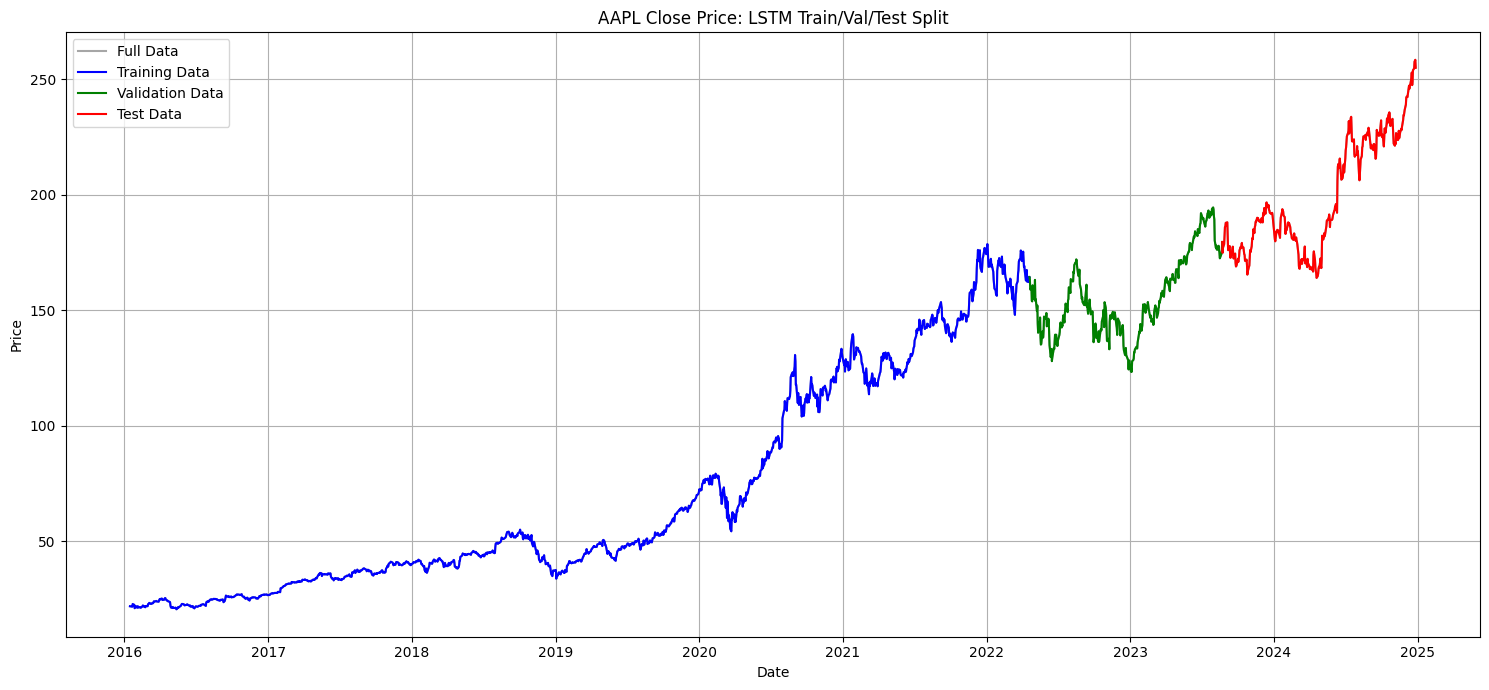

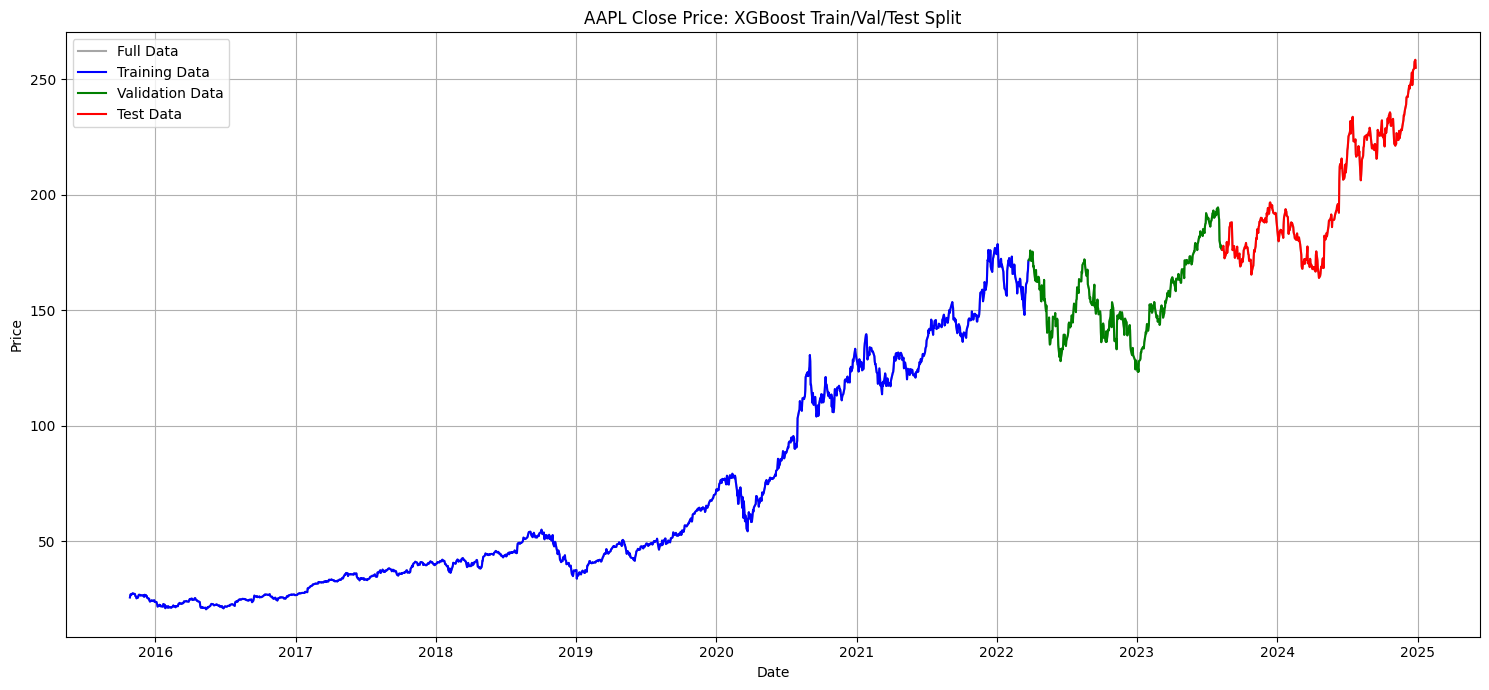

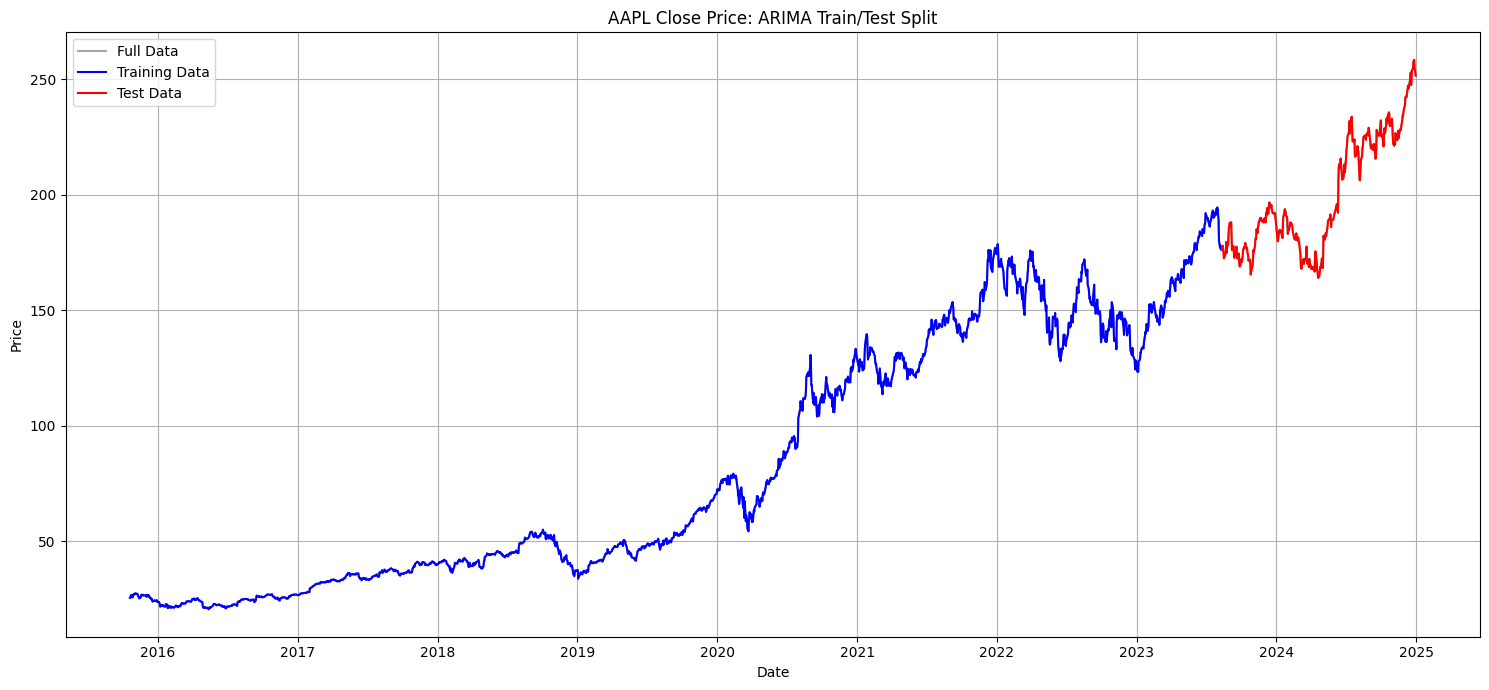

In [8]:
# Graphical Representation of Data Split (for one ticker and each model type)
print("\n--- Visualizing Train/Validation/Test Split for Prepared Data ---")

# Select a sample ticker for plotting that has data for at least one model
sample_ticker_for_plot = None
for ticker_name in Tickers:
    if any(ticker_name in prepared_data_for_all_models[m] for m in prepared_data_for_all_models):
        sample_ticker_for_plot = ticker_name
        break

if sample_ticker_for_plot:
    print(f"Visualizing splits for: {sample_ticker_for_plot}")

    # Plot for LSTM data split
    if sample_ticker_for_plot in prepared_data_for_all_models['lstm']:
        p_data_lstm = prepared_data_for_all_models['lstm'][sample_ticker_for_plot]
        if p_data_lstm:
            plt.figure(figsize=(15, 7))
            full_series = p_data_lstm['original_df_after_preprocessing'][TARGET_COLUMN]

            # Get the exact index for splits from the raw data before LSTM sequence creation
            train_end_idx = p_data_lstm['X_train_raw'].index[-1]
            val_end_idx = p_data_lstm['X_val_raw'].index[-1]

            plt.plot(full_series.index, full_series, label='Full Data', color='gray', alpha=0.7)
            plt.plot(full_series.loc[:train_end_idx].index, full_series.loc[:train_end_idx], label='Training Data', color='blue')
            plt.plot(full_series.loc[train_end_idx:val_end_idx].index, full_series.loc[train_end_idx:val_end_idx], label='Validation Data', color='green')
            plt.plot(full_series.loc[val_end_idx:].index, full_series.loc[val_end_idx:], label='Test Data', color='red')

            plt.title(f'{sample_ticker_for_plot} {TARGET_COLUMN} Price: LSTM Train/Val/Test Split')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No LSTM data to plot splits for {sample_ticker_for_plot}.")

    # Plot for XGBoost data split
    if sample_ticker_for_plot in prepared_data_for_all_models['xgboost']:
        p_data_xgb = prepared_data_for_all_models['xgboost'][sample_ticker_for_plot]
        if p_data_xgb:
            plt.figure(figsize=(15, 7))
            full_series = p_data_xgb['original_df_after_preprocessing'][TARGET_COLUMN]

            # Get the exact index for splits from the raw data for XGBoost
            train_end_idx = p_data_xgb['X_train'].index[-1]
            val_end_idx = p_data_xgb['X_val'].index[-1]

            plt.plot(full_series.index, full_series, label='Full Data', color='gray', alpha=0.7)
            plt.plot(full_series.loc[:train_end_idx].index, full_series.loc[:train_end_idx], label='Training Data', color='blue')
            plt.plot(full_series.loc[train_end_idx:val_end_idx].index, full_series.loc[train_end_idx:val_end_idx], label='Validation Data', color='green')
            plt.plot(full_series.loc[val_end_idx:].index, full_series.loc[val_end_idx:], label='Test Data', color='red')

            plt.title(f'{sample_ticker_for_plot} {TARGET_COLUMN} Price: XGBoost Train/Val/Test Split')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No XGBoost data to plot splits for {sample_ticker_for_plot}.")

    # Plot for ARIMA data split
    if sample_ticker_for_plot in prepared_data_for_all_models['arima']:
        p_data_arima = prepared_data_for_all_models['arima'][sample_ticker_for_plot]
        if p_data_arima:
            plt.figure(figsize=(15, 7))
            full_series_original = p_data_arima['original_full_series']

            # Get the exact index for splits for ARIMA
            train_end_idx = p_data_arima['train_data'].index[-1]

            plt.plot(full_series_original.index, full_series_original, label='Full Data', color='gray', alpha=0.7)
            plt.plot(full_series_original.loc[:train_end_idx].index, full_series_original.loc[:train_end_idx], label='Training Data', color='blue')
            plt.plot(full_series_original.loc[train_end_idx:].index, full_series_original.loc[train_end_idx:], label='Test Data', color='red')

            plt.title(f'{sample_ticker_for_plot} {TARGET_COLUMN} Price: ARIMA Train/Test Split')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No ARIMA data to plot splits for {sample_ticker_for_plot}.")

else:
    print("No sample ticker found with prepared data for any model to plot splits.")

## LSTM Model

In [ ]:
print("\n" + "="*50)
print("             STARTING LSTM MODEL PROCESS")
print("="*50)

# Restating Paramenters
LOOK_BACK = 60
TARGET_COLUMN = 'Close'

# LSTM Model Definition
def build_lstm_model(input_shape):
    """
    Builds a Sequential LSTM model.
    input_shape: A tuple (timesteps, features) for the LSTM input layer.
    """
    model = Sequential([
        LSTM(units=100, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(units=100, return_sequences=False),
        Dropout(0.3),
        Dense(units=1) # Output layer for predicting single 'Close' price
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Dictionaries to store LSTM results
lstm_trained_models = {}
lstm_evaluation_results = {}
lstm_predictions = {}

# LSTM Training and Evaluation Loop
print("\n Training and Evaluating LSTM Models ")

# Iterate through each ticker, checking if LSTM data is prepared
for ticker in Tickers:
    if ticker in prepared_data_for_all_models['lstm']:
        print(f"\n Processing LSTM for {ticker} ")
        lstm_data = prepared_data_for_all_models['lstm'][ticker]

        X_train_lstm = lstm_data['X_train_lstm']
        y_train_lstm = lstm_data['y_train_lstm']
        X_val_lstm = lstm_data['X_val_lstm']
        y_val_lstm = lstm_data['y_val_lstm']
        X_test_lstm = lstm_data['X_test_lstm']
        y_test_lstm = lstm_data['y_test_lstm']
        scaler_y_lstm = lstm_data['scaler_y']

        # Check data after sequence creation for LSTM
        if X_train_lstm.shape[0] == 0 or X_val_lstm.shape[0] == 0 or X_test_lstm.shape[0] == 0:
            print(f"Not enough LSTM sequences for {ticker} after look_back ({LOOK_BACK}).")
            continue

        # Model Definition
        lstm_model = build_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        # Model Training
        print(f"  Training LSTM model for {ticker}...")
        history = lstm_model.fit(
            X_train_lstm, y_train_lstm,
            epochs=200,
            batch_size=32,
            validation_data=(X_val_lstm, y_val_lstm),
            callbacks=[early_stopping],
            verbose=0
        )
        lstm_trained_models[ticker] = lstm_model

        # Prediction and Inverse Scaling
        print(f"  Making LSTM predictions for {ticker}...")
        y_pred_scaled_lstm = lstm_model.predict(X_test_lstm, verbose=0)
        y_test_original_lstm = scaler_y_lstm.inverse_transform(y_test_lstm)
        y_pred_original_lstm = scaler_y_lstm.inverse_transform(y_pred_scaled_lstm)

        # Model Evaluation
        rmse_lstm = np.sqrt(mean_squared_error(y_test_original_lstm, y_pred_original_lstm))
        mae_lstm = mean_absolute_error(y_test_original_lstm, y_pred_original_lstm)
        r2_lstm = r2_score(y_test_original_lstm, y_pred_original_lstm)

        lstm_evaluation_results[ticker] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'R2': r2_lstm}
        lstm_predictions[ticker] = {'actual': y_test_original_lstm, 'predicted': y_pred_original_lstm}

        print(f"  LSTM Results for {ticker}: RMSE={rmse_lstm:.4f}, MAE={mae_lstm:.4f}, R2={r2_lstm:.4f}")
    else:
        print(f"--- No prepared LSTM data found for {ticker}. Skipping LSTM. ---")

print("\n Summary of LSTM Model Evaluation Results ")
if lstm_evaluation_results:
    for ticker, metrics in lstm_evaluation_results.items():
        print(f"  {ticker}: RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}, R2={metrics['R2']:.4f}")
else:
    print("  No LSTM models were trained or evaluated.")

print("\n" + "="*50)
print("             LSTM MODEL PROCESS COMPLETE")
print("="*50)



             STARTING LSTM MODEL PROCESS

 Training and Evaluating LSTM Models 

 Processing LSTM for AAPL 
  Training LSTM model for AAPL...
  Making LSTM predictions for AAPL...
  LSTM Results for AAPL: RMSE=25.1552, MAE=19.4850, R2=-0.0469

 Processing LSTM for MSFT 
  Training LSTM model for MSFT...
  Making LSTM predictions for MSFT...
  LSTM Results for MSFT: RMSE=70.8661, MAE=67.8290, R2=-9.1125

 Processing LSTM for GOOGL 
  Training LSTM model for GOOGL...
  Making LSTM predictions for GOOGL...
  LSTM Results for GOOGL: RMSE=23.2743, MAE=19.0967, R2=-0.9102

 Processing LSTM for AMZN 
  Training LSTM model for AMZN...
  Making LSTM predictions for AMZN...
  LSTM Results for AMZN: RMSE=18.6108, MAE=13.8479, R2=0.0999

 Processing LSTM for NVDA 
  Training LSTM model for NVDA...
  Making LSTM predictions for NVDA...
  LSTM Results for NVDA: RMSE=76.8148, MAE=70.0935, R2=-5.0751

 Processing LSTM for META 
  Training LSTM model for META...
  Making LSTM predictions for META...
 

### Visualization of LSTM Model

In [1]:
# Visualization of LSTM Predictions
print("\n Visualizing LSTM Predictions")

# Select a sample ticker for LSTM plotting
sample_ticker_for_lstm_plot = None
for ticker_name in Tickers:
    if ticker_name in lstm_predictions:
        sample_ticker_for_lstm_plot = ticker_name
        break

if sample_ticker_for_lstm_plot:
    print(f"\n Visualizing LSTM predictions for {sample_ticker_for_lstm_plot}")
    lstm_actual = lstm_predictions[sample_ticker_for_lstm_plot]['actual']
    lstm_predicted = lstm_predictions[sample_ticker_for_lstm_plot]['predicted']

    # Get test dates for LSTM
    lstm_data = prepared_data_for_all_models['lstm'][sample_ticker_for_lstm_plot]
    y_test_raw_full_series = lstm_data['y_test_raw']
    lstm_test_dates = y_test_raw_full_series.index[LOOK_BACK : LOOK_BACK + len(lstm_actual)]

    plt.figure(figsize=(16, 6))
    plt.plot(lstm_test_dates, lstm_actual, label='Actual Prices', color='blue')
    plt.plot(lstm_test_dates, lstm_predicted, label='Predicted Prices (LSTM)', color='red', linestyle='--')
    plt.title(f'{sample_ticker_for_lstm_plot} Stock Price Prediction - LSTM')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No LSTM predictions available for visualization.")




 Visualizing LSTM Predictions


NameError: name 'Tickers' is not defined